# Medallion Architecture: Healthcare Example with Pandas

## 👩‍💼 **Scenario:**
Lumos has landed a project working with a healthcare provider. Your client has access to synthetic patient data generated from Synthea, which simulates real-world medical records. The client needs help building a structured pipeline to analyze patient and encounter data in a way that supports business intelligence and decision-making.

Your task as a Data Engineer is to build a medallion architecture pipeline with the following objectives:
 
1. Load and inspect raw patient, encounter, and medication data.
2. Clean and prepare the data into consistent, analysis-ready tables.
3. Create enriched views by joining datasets to gain a full picture of the patient journey.
4. Calculate and save key performance indicators (KPIs).
5. Generate visualizations to support reporting.

# 🥉 BRONZE LAYER

The raw data landing zone. It contains unprocessed datasets as extracted from the source. No cleaning or transformations are done here, just data dumps.

We'll use real-world-style healthcare datasets generated from Synthea: patients, encounters, and medications.


In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Create folder structure
os.makedirs("bronze", exist_ok=True)
os.makedirs("silver", exist_ok=True)
os.makedirs("gold", exist_ok=True)

### 🧩 **Step 1 - Load and Inspect:**
The client has given you access to raw healthcare datasets, already loaded up in bronze. The job here is simple:
 
- Load the CSV files from the Synthea data dump.
- Explore them to understand what kind of information you're working with.
- Do not modify the data yet — just inspect and get familiar with it.

In [92]:
patients = pd.read_csv("bronze/patients.csv")
encounters = pd.read_csv("bronze/encounters.csv")
medications = pd.read_csv("bronze/medications.csv")

After loading the data, ask yourself the following:
1. How many columns and rows are in each dataset?
2. Which columns look like IDs or date values?
3. Can you spot any missing values or strange formatting?

Explore and Inspect Raw Data (Optional (but recommended))

In [93]:
print("Patients:")
print(patients.head())
print("\nEncounters:")
print(encounters.head())
print("\nMedications:")
print(medications.head())

Patients:
                                     Id   BIRTHDATE DEATHDATE          SSN  \
0  a810b3cd-a8fa-0288-5f7c-c6347674d155  2023-01-21       NaN  999-28-3771   
1  aa59ccda-f100-6d3a-9735-a9d61e1fbae1  2014-02-22       NaN  999-47-3154   
2  6bb306f5-8ddf-6ce9-d504-5ec40385aee1  1973-01-04       NaN  999-97-3347   
3  a438167e-e1a2-079b-7707-3ba6b6bd5200  1957-02-16       NaN  999-23-3986   
4  e18295b7-25c7-25f3-45c9-6e473e3df7a6  2013-09-17       NaN  999-94-4650   

     DRIVERS    PASSPORT PREFIX        FIRST     MIDDLE        LAST  ...  \
0        NaN         NaN    NaN      Josh874  Hassan290     King743  ...   
1        NaN         NaN    NaN  Violette536  Hettie215    Jones311  ...   
2  S99947865  X69812505X    Mr.    Carlos172        NaN    Kiehn525  ...   
3  S99912795  X17191035X    Mr.     Craig656  Hilton264  Hagenes547  ...   
4        NaN         NaN    NaN    Lauren941   Shawn523    Blick895  ...   

         CITY          STATE            COUNTY     FIPS   ZIP   

# 🥈 SILVER LAYER
Cleaned and normalized data. 

This stage standardises formats, filters out invalid or missing data, and prepares it for analysis by applying business logic and transformations. It can also include enriched datasets formed by joining multiple sources.

### 🛠️ **Step 2 – Build Trustworthy Tables:**
Now it’s time to prepare the data for analysis. We'll clean each dataset separately:
 
- Rename inconsistent column names
- Drop null or malformed values
- Convert strings to proper data types (especially for dates)
- The client would also like all datetimes to be in UTC timezone.
 
Complete and run the cleaning functions. Then:
1. Print the shape and dtypes of each cleaned table.
2. Try spot any patient entries that might still be problematic.
3. Check if any medications were dropped due to missing encounters.

In [94]:
def clean_patients(df):
    df.columns = df.columns.str.lower()
    df = df.dropna(subset=['id'])
    df = df.rename(columns={'id': 'patient_id'})
    return df[['patient_id', 'birthdate', 'gender', 'race', 'ethnicity', 'marital', 'state', 'city']]

def clean_encounters(df):
    df.columns = df.columns.str.lower()
    df = df.dropna(subset=['id', 'patient'])
    df = df.rename(columns={'id': 'encounter_id', 'patient': 'patient_id'})
    df['encounter_start'] = pd.to_datetime(df['start'], errors='coerce', utc=True)
    df['encounter_end'] = pd.to_datetime(df['stop'], errors='coerce', utc=True)
    df['encounter_month'] = df['encounter_start'].dt.to_period('M')
    return df[['encounter_id', 'patient_id', 'encounter_start', 'encounter_end', 'encounterclass', 'reasoncode', 'encounter_month']]

def clean_medications(df):
    df.columns = df.columns.str.lower()
    df = df.dropna(subset=['encounter'])
    df = df.rename(columns={'encounter': 'encounter_id'})
    return df[['encounter_id', 'description', 'start', 'stop', 'reasoncode']]

In [95]:
patients_clean = clean_patients(patients)
encounters_clean = clean_encounters(encounters)
medications_clean = clean_medications(medications)

C:\Users\aleks\AppData\Local\Temp\ipykernel_34416\2099219342.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['encounter_month'] = df['encounter_start'].dt.to_period('M')


Save cleaned data to the `silver/` folder.

In [96]:
patients_clean.to_csv("silver/patients_clean.csv", index=False)
encounters_clean.to_csv("silver/encounters_clean.csv", index=False)
medications_clean.to_csv("silver/medications_clean.csv", index=False)

### 🔗 **Step 3 – Connect the Dots:**
You now have cleaned tables. Let’s enrich the data:
 
- Join patients with their encounters
- Join encounters with medication records
- Create two derived metrics : the patient's age at the time of the encounter, and the total medications prescribed per encounter.

In [97]:
encounters_patients = encounters_clean.merge(patients_clean, on='patient_id', how='left')
encounters_full = encounters_patients.merge(
    medications_clean,
    on='encounter_id',
    how='left'
)
print(encounters_full.head())

                           encounter_id                            patient_id  \
0  eabe2d17-dc0c-54dd-d791-df1a6afffb74  a810b3cd-a8fa-0288-5f7c-c6347674d155   
1  2cd689e1-828a-8ec1-1fa4-65c181b9e27c  aa59ccda-f100-6d3a-9735-a9d61e1fbae1   
2  646ca376-0e3b-8641-e3ff-f2637a1800a6  a810b3cd-a8fa-0288-5f7c-c6347674d155   
3  eab75d7d-a429-4655-2181-16338c07bc68  a810b3cd-a8fa-0288-5f7c-c6347674d155   
4  8b455020-0438-0955-8c21-50ebbebf52c0  aa59ccda-f100-6d3a-9735-a9d61e1fbae1   

            encounter_start             encounter_end encounterclass  \
0 2023-01-21 21:52:07+00:00 2023-01-21 22:07:07+00:00       wellness   
1 2015-05-02 03:42:27+00:00 2015-05-02 03:57:27+00:00       wellness   
2 2023-02-25 21:52:07+00:00 2023-02-25 22:07:07+00:00       wellness   
3 2023-04-29 21:52:07+00:00 2023-04-29 22:07:07+00:00       wellness   
4 2015-08-01 03:42:27+00:00 2015-08-01 03:57:27+00:00       wellness   

   reasoncode_x encounter_month   birthdate gender   race    ethnicity  \
0     

Add age at time of encounter

In [98]:
encounters_full['birthdate'] = pd.to_datetime(encounters_full['birthdate'], utc=True)
encounters_full['age_at_encounter'] = ((encounters_full['encounter_start'] - encounters_full['birthdate']).dt.days / 365.25).astype(int)

Add total medications prescribed per encounter

In [99]:
# Calculate number of medications per encounter
meds_per_encounter = medications_clean.groupby('encounter_id').size().reset_index(name='total_meds')

# Add to enriched dataset
encounters_full = encounters_full.merge(meds_per_encounter, on='encounter_id', how='left')
encounters_full['total_meds'] = encounters_full['total_meds'].fillna(0).astype(int)


Save enriched dataset in silver/

In [100]:
encounters_full.to_csv("silver/encounters_full.csv", index=False)

After enriching the data:
1. How many unique patients have medication records?
2. What’s the average age of patients during encounters?
3. What percentage of encounters involve at least one medication?

In [101]:
unique_meds_patients = encounters_full[~encounters_full['description'].isna()]['patient_id'].nunique()
print("Unique patients with at least one medication record:", unique_meds_patients)

avg_age_at_encounter = encounters_full['age_at_encounter'].mean().round(1)
print("Average age at time of encounter:", avg_age_at_encounter)

percent_with_meds = (encounters_full['total_meds'] > 0).mean() * 100
print(f"Percentage of encounters with at least one medication: {percent_with_meds:.2f}%")

Unique patients with at least one medication record: 112
Average age at time of encounter: 49.6
Percentage of encounters with at least one medication: 59.45%


# 🥇 GOLD LAYER
The final presentation layer. 
Contains aggregated, curated data suitable for reporting and decision-making. Here we compute KPIs and create visualizations to derive insights.
### 📊 **Step 4 – Business Insights for Decision Makers:**
It’s time to summarise the data into useful metrics (KPIs) and charts that executives and analysts can use.
You’ll compute:

- How many times patients typically interact with care providers
- The top reasons people visit clinics
- Which age groups are prescribed the most medication

### KPI 1: Average number of encounters per patient
This metric helps understand how often patients are interacting with the healthcare system.

A higher number may indicate a population with frequent care needs, while a lower number could
suggest healthier individuals or gaps in access to care.

Calculate the number of encounters grouped per patient and then compute the average across all patients.


In [102]:
encounters_df = pd.read_csv("silver/encounters_full.csv")
encounters_per_patient = encounters_df.groupby('patient_id').size()
avg_encounters = encounters_per_patient.mean().round(2)
print("Average Encounters per Patient:", avg_encounters)

Average Encounters per Patient: 90.97


### KPI 2: Top 5 most common encounter reasons

This metric identifies the most frequently cited reasons for patient visits.
It helps healthcare providers understand common health issues or patterns in patient demand.

Knowing the most common reasons for encounters can support decisions about resource allocation and patient education.


In [103]:
top_reasons = encounters_clean['reasoncode'].value_counts().head(5)
print("\nTop 5 Encounter Reasons:\n", top_reasons)


Top 5 Encounter Reasons:
 reasoncode
431857002.0    1391
46177005.0     1027
88805009.0      496
72892002.0      486
389095005.0     332
Name: count, dtype: int64


### KPI 3: Medication frequency by age group
This metric analyzes how often medications are prescribed across different age groups.
It offers insight into age-specific treatment patterns, highlighting where chronic conditions or high medication use may be concentrated.

Grouping by age allows healthcare professionals to tailor preventive care and monitor age-related trends in prescriptions.


In [104]:
# bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '66+']

encounters_full['age_group'] = pd.cut(encounters_full['age_at_encounter'], bins=[0, 18, 35, 50, 65, 100], labels=['0-18', '19-35', '36-50', '51-65', '66+'])
med_by_age = encounters_full.groupby('age_group')['description'].count()

C:\Users\aleks\AppData\Local\Temp\ipykernel_34416\1832764839.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  med_by_age = encounters_full.groupby('age_group')['description'].count()


### Save KPIs in gold

In [105]:
pd.DataFrame({'avg_encounters': [avg_encounters]}).to_csv("gold/avg_encounters.csv", index=False)
top_reasons.to_frame(name="count").to_csv("gold/top_reasons.csv")
med_by_age.to_frame(name="medication_count").to_csv("gold/medications_by_age.csv")

## 📊 Visualize a KPI (dealer's choice)

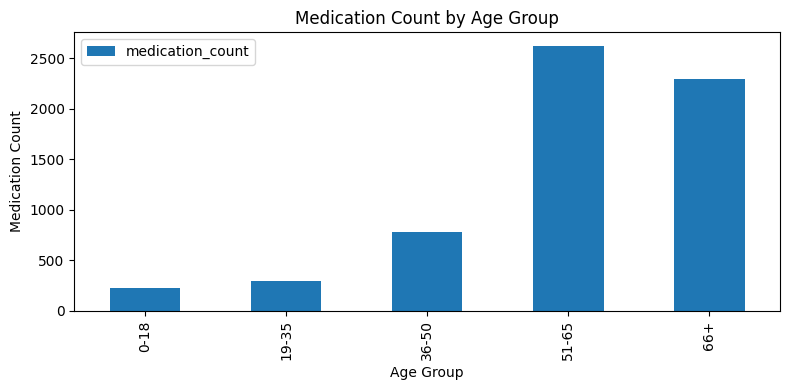

In [106]:
med_by_age = pd.read_csv("gold/medications_by_age.csv", index_col=0)
med_by_age.plot(kind='bar', title='Medication Count by Age Group', figsize=(8,4))
plt.xlabel('Age Group')
plt.ylabel('Medication Count')
plt.tight_layout()
plt.savefig("gold/medication_by_age_plot.png")
plt.show()

### 🧠 **Bonus Challenge:**
1. Identify which age group has the most prescriptions.
2. Can you interpret what the top 3 encounter reasons suggest about patient needs?
3. Create one additional visualization that could be helpful to your client (e.g. encounter type by gender).

✅ Age group with the most prescriptions: medication_count    51-65
dtype: object

✅ Top 3 Encounter Reasons and Their Implications:
- 431857002.0: 1391 visits
- 46177005.0: 1027 visits
- 88805009.0: 496 visits


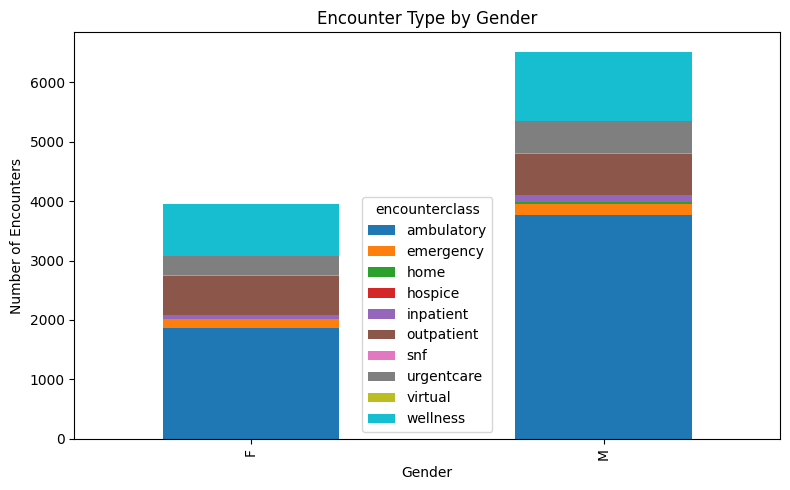

In [107]:
# %%
# 1. Age group with the most prescriptions
most_prescriptions_age_group = med_by_age.idxmax()
print("✅ Age group with the most prescriptions:", most_prescriptions_age_group)

# 2. Interpret top 3 encounter reasons
print("\n✅ Top 3 Encounter Reasons and Their Implications:")
for reason, count in top_reasons.head(3).items():
    print(f"- {reason}: {count} visits")

# 3. Extra visualization: Encounter type by gender
encounter_type_by_gender = encounters_full.groupby(['gender', 'encounterclass']).size().unstack().fillna(0)
encounter_type_by_gender.plot(kind='bar', stacked=True, figsize=(8, 5), title='Encounter Type by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Encounters')
plt.tight_layout()
plt.savefig("gold/encounter_type_by_gender_plot.png")
plt.show()